In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [51]:
stock_symbol = ('TSLA')
start_date = '2020-01-01'
end_date = '2024-01-01'
data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [52]:
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

In [53]:
def create_lstm_data(data, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(x), np.array(y)

time_steps = 10
x, y = create_lstm_data(close_prices_scaled, time_steps)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))


In [54]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x, y, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 5s 11ms/step - loss: 0.0446
Epoch 2/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0038
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0023
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 7/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 8/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 9/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 10/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 11/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 12/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 13/50
32/32 [==================

In [55]:
# Prepare the input for prediction
x_pred = np.array([close_prices_scaled[-time_steps:, 0]])
x_pred = np.reshape(x_pred, (x_pred.shape[0], x_pred.shape[1], 1))

# Predict and inverse transform the scaled predictions
predicted_price_scaled = model.predict(x_pred)
predicted_price = scaler.inverse_transform(predicted_price_scaled)


1/1 [==============================] - 1s 864ms/step


32/32 [==============================] - 0s 5ms/step


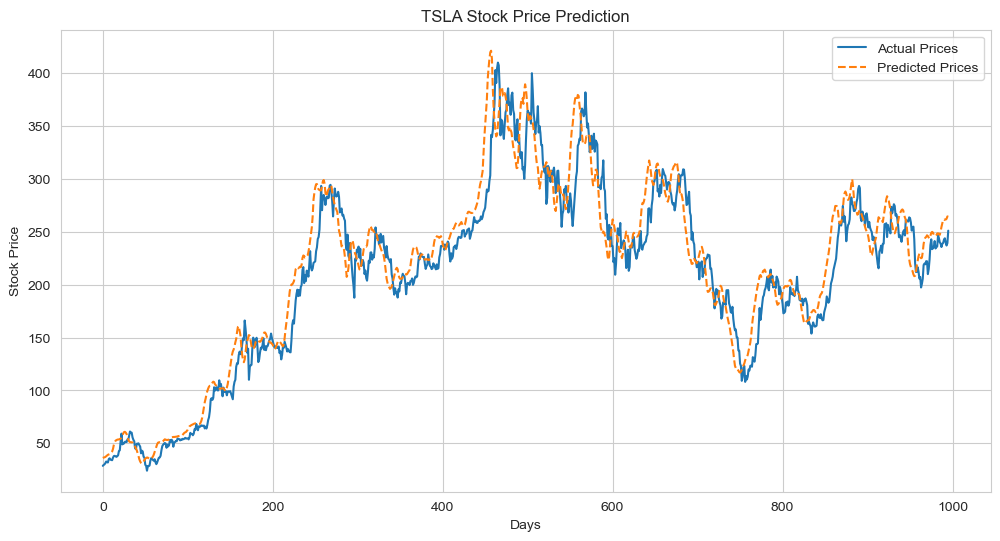

In [56]:
# Get model predictions on training data
train_predictions = model.predict(x)
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))

# Get actual prices
actual_prices = scaler.inverse_transform(close_prices_scaled[:len(train_predictions)])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(train_predictions, label='Predicted Prices', linestyle='dashed')
plt.title(f"{stock_symbol} Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [1]:
# Predict the next 30 days
n_days = 30

# Start with the last `time_steps` values as input
last_data = close_prices_scaled[-time_steps:]
last_data = np.reshape(last_data, (1, time_steps, 1))

# Predict the future prices
future_predictions = []
for _ in range(n_days):
    predicted_value = model.predict(last_data)
    future_predictions.append(predicted_value[0][0])

    # Update the input data with the predicted value
    last_data = np.append(last_data[:, 1:, :], predicted_value.reshape(1, 1, 1), axis=1)

# Inverse transform the scaled values back to original prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a date range for the future dates
last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=n_days + 1, freq='B')[1:]

# Create a DataFrame to visualize the future predictions
future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted Close'])

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Historical Prices')
plt.plot(future_df.index, future_df['Predicted Close'], label='Future Predictions', color='orange')
plt.title(f'{stock_symbol} - Stock Price Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


NameError: name 'close_prices_scaled' is not defined